In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from tabulate import tabulate

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {
    'n_clusters': 32,
    'batch_size': 256,
    'epochs': 15,
    'learning_rate': 0.01,
    'momentum': 0.9,
    'model': 'resnet18',
    'dataset': 'CIFAR10'
}

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_set = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

100%|██████████| 170M/170M [00:15<00:00, 11.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
test_set = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=config['batch_size'],
    shuffle=True
)

In [7]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=config['batch_size'],
    shuffle=False
)

In [8]:
def create_model():
    model = torchvision.models.resnet18(num_classes=10)
    return model.to(device)


original_model = create_model()
clustered_model = create_model()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    original_model.parameters(),
    lr=config['learning_rate'],
    momentum=config['momentum']
)

In [10]:
for epoch in range(config['epochs']):
    original_model.train()
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = original_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Эпоха {epoch+1}/{config['epochs']}, Loss: {running_loss/len(train_loader):.4f}")

Эпоха 1/15, Loss: 1.5717
Эпоха 2/15, Loss: 1.1562
Эпоха 3/15, Loss: 0.9408
Эпоха 4/15, Loss: 0.7663
Эпоха 5/15, Loss: 0.6293
Эпоха 6/15, Loss: 0.5042
Эпоха 7/15, Loss: 0.3960
Эпоха 8/15, Loss: 0.3174
Эпоха 9/15, Loss: 0.2619
Эпоха 10/15, Loss: 0.1995
Эпоха 11/15, Loss: 0.1566
Эпоха 12/15, Loss: 0.1284
Эпоха 13/15, Loss: 0.1044
Эпоха 14/15, Loss: 0.1007
Эпоха 15/15, Loss: 0.0749


In [11]:
clustered_model.load_state_dict(original_model.state_dict())

<All keys matched successfully>

In [12]:
def cluster_weights(model, n_clusters):
    """кластеризация весов с помощью k-means"""
    for name, param in model.named_parameters():
        # пропускаем bias и batchnorm слои
        if 'weight' in name and len(param.shape) >= 2:
            print(f"Кластеризация слоя: {name}")
            
            weights = param.data.cpu().numpy()
            original_shape = weights.shape
            
            kmeans = KMeans(
                n_clusters=n_clusters,
                n_init=10
            ).fit(weights.reshape(-1, 1))
            
            clustered = kmeans.cluster_centers_[kmeans.labels_]
            param.data = torch.tensor(
                clustered.reshape(original_shape),
                dtype=param.dtype
            ).to(param.device)

In [13]:
cluster_weights(clustered_model, config['n_clusters'])

Кластеризация слоя: conv1.weight
Кластеризация слоя: layer1.0.conv1.weight
Кластеризация слоя: layer1.0.conv2.weight
Кластеризация слоя: layer1.1.conv1.weight
Кластеризация слоя: layer1.1.conv2.weight
Кластеризация слоя: layer2.0.conv1.weight
Кластеризация слоя: layer2.0.conv2.weight
Кластеризация слоя: layer2.0.downsample.0.weight
Кластеризация слоя: layer2.1.conv1.weight
Кластеризация слоя: layer2.1.conv2.weight
Кластеризация слоя: layer3.0.conv1.weight
Кластеризация слоя: layer3.0.conv2.weight
Кластеризация слоя: layer3.0.downsample.0.weight
Кластеризация слоя: layer3.1.conv1.weight
Кластеризация слоя: layer3.1.conv2.weight
Кластеризация слоя: layer4.0.conv1.weight
Кластеризация слоя: layer4.0.conv2.weight
Кластеризация слоя: layer4.0.downsample.0.weight
Кластеризация слоя: layer4.1.conv1.weight
Кластеризация слоя: layer4.1.conv2.weight
Кластеризация слоя: fc.weight


In [14]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    times = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            start = time.time()
            outputs = model(inputs)
            times.append(time.time() - start)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return {
        'accuracy': 100 * correct / total,
        'loss': total_loss / len(dataloader),
        'avg_inference_time': np.mean(times) * 1000,
        'throughput': len(dataloader.dataset) / sum(times)
    }

In [15]:
original_metrics = evaluate_model(original_model, test_loader)
clustered_metrics = evaluate_model(clustered_model, test_loader)

In [16]:
def get_model_size(model):
    torch.save(model.state_dict(), 'temp.pth')
    size = os.path.getsize('temp.pth')
    os.remove('temp.pth')
    return size / (1024**2)

In [17]:
metrics = {
    'Метрика': ['Точность (%)', 'Потери', 
               'Среднее время инференса (мс)', 
               'Пропускная способность (изобр/сек)',
               'Размер модели (MB)'],
    'Оригинал': [
        original_metrics['accuracy'],
        original_metrics['loss'],
        original_metrics['avg_inference_time'],
        original_metrics['throughput'],
        get_model_size(original_model)
    ],
    'Кластеризация': [
        clustered_metrics['accuracy'],
        clustered_metrics['loss'],
        clustered_metrics['avg_inference_time'],
        clustered_metrics['throughput'],
        get_model_size(clustered_model)
    ]
}

In [18]:
df = pd.DataFrame(metrics)
df['Разница'] = df['Кластеризация'] - df['Оригинал']
df['Изменение (%)'] = (df['Кластеризация'] / df['Оригинал'] - 1) * 100

In [19]:
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

+------------------------------------+-------------+-----------------+---------------+-----------------+
| Метрика                            |    Оригинал |   Кластеризация |       Разница |   Изменение (%) |
+====================================+=============+=================+===============+=================+
| Точность (%)                       |    69.07    |        69.12    |     0.05      |       0.0723903 |
+------------------------------------+-------------+-----------------+---------------+-----------------+
| Потери                             |     1.69101 |         1.67026 |    -0.0207524 |      -1.22722   |
+------------------------------------+-------------+-----------------+---------------+-----------------+
| Среднее время инференса (мс)       |     3.34545 |         2.55057 |    -0.794882  |     -23.7601    |
+------------------------------------+-------------+-----------------+---------------+-----------------+
| Пропускная способность (изобр/сек) | 74728.4     |   

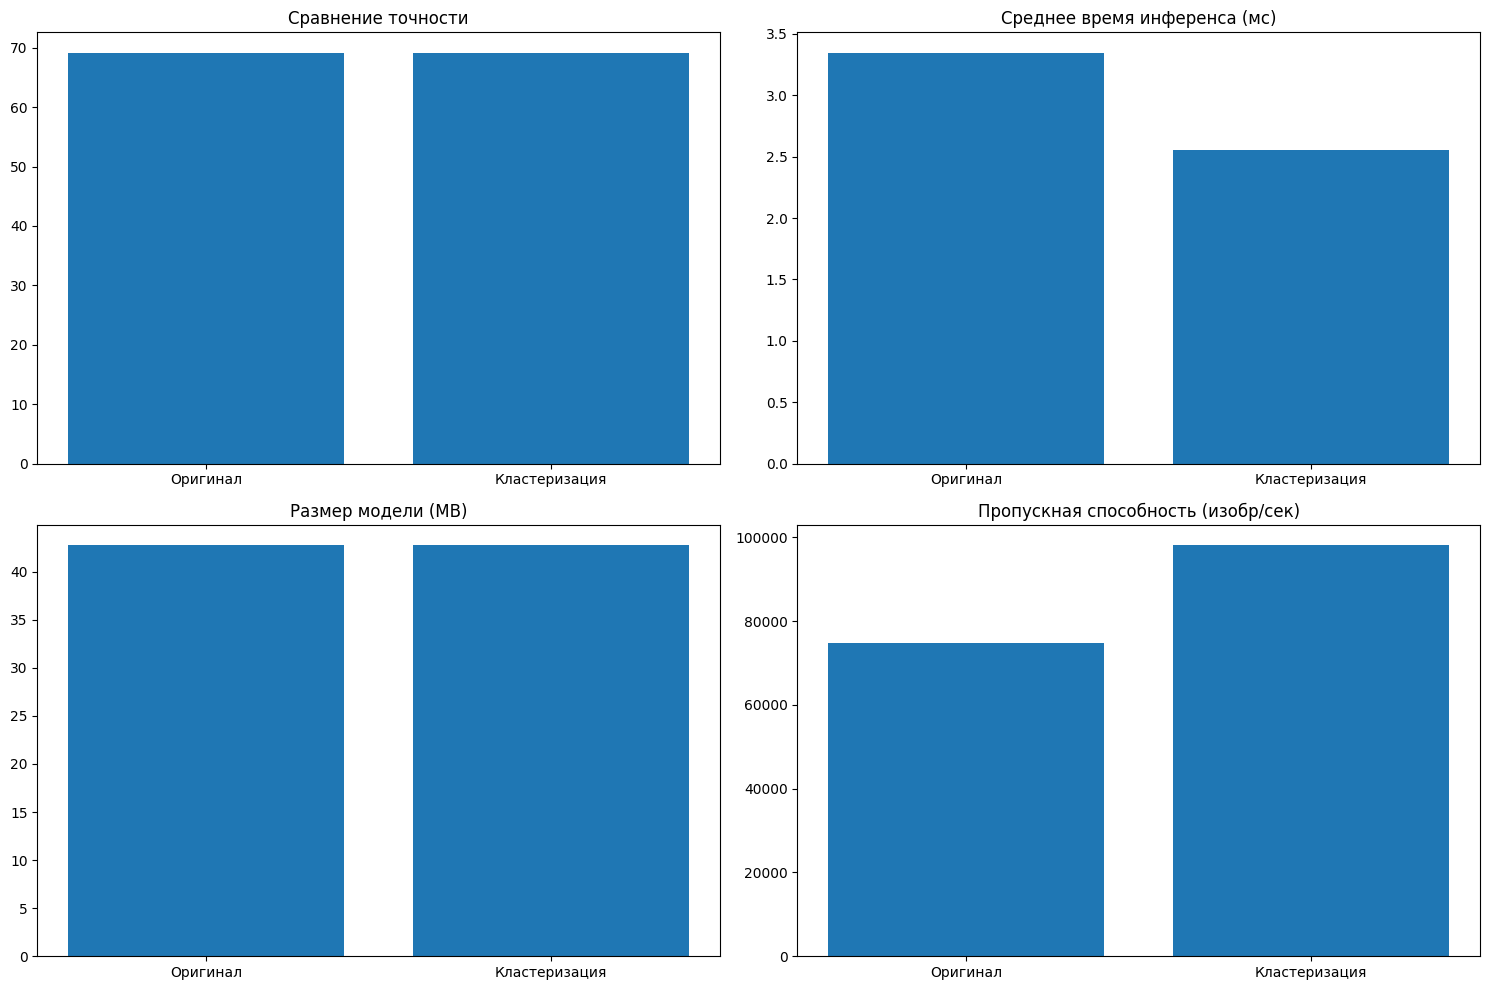

In [20]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.bar(['Оригинал', 'Кластеризация'], 
        [original_metrics['accuracy'], clustered_metrics['accuracy']])
plt.title('Сравнение точности')

plt.subplot(2,2,2)
plt.bar(['Оригинал', 'Кластеризация'], 
        [original_metrics['avg_inference_time'], clustered_metrics['avg_inference_time']])
plt.title('Среднее время инференса (мс)')

plt.subplot(2,2,3)
plt.bar(['Оригинал', 'Кластеризация'], 
        [get_model_size(original_model), get_model_size(clustered_model)])
plt.title('Размер модели (MB)')

plt.subplot(2,2,4)
plt.bar(['Оригинал', 'Кластеризация'], 
        [original_metrics['throughput'], clustered_metrics['throughput']])
plt.title('Пропускная способность (изобр/сек)')

plt.tight_layout()
plt.show()